In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Constants ---
RATED_VOLTAGE = 58.8
BASE_IMPEDANCE = 85
AMBIENT_TEMP = 28
CAPACITY_WH = 2900
FRONT_PSI_INIT, REAR_PSI_INIT = 22.1, 36.0
FRONT_PSI_MIN, REAR_PSI_MIN = 20.0, 34.0
np.random.seed(42)

# --- Simulation Parameters ---
num_days = 25
ride_duration_min = 30
interval_sec = 5
samples_per_ride = int((ride_duration_min * 60) / interval_sec)
total_rides = num_days * 2

def simulate_rides():
    records = []
    front_psi = FRONT_PSI_INIT
    rear_psi = REAR_PSI_INIT
    psi_degrade_per_ride = 0.025  # slow daily loss

    for day in range(num_days):
        for ride_num, hour in enumerate([8, 18]):
            # --- Reset variables at start of each ride ---
            motor_current = []
            motor_temp = [AMBIENT_TEMP]
            battery_voltage = []
            discharge_current = []
            battery_temp = [AMBIENT_TEMP]
            voltage_diff = []
            battery_impedance = []
            speed = []
            regen_triggered = []
            ride_mode = []
            soc = []
            # Tyre pressure: degrade, but allow rare puncture/reset
            if np.random.rand() < 0.04:  # 4% chance of puncture
                front_psi = np.random.uniform(FRONT_PSI_MIN, FRONT_PSI_MIN + 0.5)
                rear_psi = np.random.uniform(REAR_PSI_MIN, REAR_PSI_MIN + 0.5)
            elif np.random.rand() < 0.04:  # 4% chance of refill/reset
                front_psi = FRONT_PSI_INIT
                rear_psi = REAR_PSI_INIT

            # Simulate ride mode and possible switch
            ride_mode_switch = np.random.randint(samples_per_ride//3, samples_per_ride//1.5)
            mode = 'Smart Eco'
            for i in range(samples_per_ride):
                # --- Timestamp ---
                timestamp = datetime(2025, 1, 1, hour, 0, 0) + timedelta(days=day, seconds=i*interval_sec)
                # --- Tyre Pressure (degrade slowly, add noise) ---
                if i == 0 and (ride_num == 0 and day == 0):
                    f_psi = front_psi
                    r_psi = rear_psi
                else:
                    f_psi = max(FRONT_PSI_MIN, front_psi - psi_degrade_per_ride/2 + np.random.normal(0, 0.03))
                    r_psi = max(REAR_PSI_MIN, rear_psi - psi_degrade_per_ride + np.random.normal(0, 0.04))
                # Random nulls
                if np.random.rand() < 0.01:
                    f_psi = np.nan
                if np.random.rand() < 0.01:
                    r_psi = np.nan
                # --- Ride Mode (max 1 switch per ride) ---
                if i == ride_mode_switch:
                    mode = 'Zip' if mode == 'Smart Eco' else 'Smart Eco'
                ride_mode.append(mode)
                # --- Rolling resistance effect ---
                rolling_resist_factor = 1 + (FRONT_PSI_INIT - (f_psi if not np.isnan(f_psi) else FRONT_PSI_INIT))/10 + (REAR_PSI_INIT - (r_psi if not np.isnan(r_psi) else REAR_PSI_INIT))/10
                # --- Speed profile ---
                if i < 1:
                    spd = np.random.uniform(3, 7)
                else:
                    if mode == 'Smart Eco':
                        spd = min(np.random.normal(45, 5), 55)
                    else:
                        spd = min(np.random.normal(65, 8), 80)
                    # Tyre pressure, rolling resistance, and battery health effect
                    spd = spd / rolling_resist_factor
                speed.append(spd)
                # --- Motor Current ---
                base_current = (spd/55)*15 if mode == 'Smart Eco' else (spd/80)*30
                psi_load = (FRONT_PSI_INIT/(f_psi if not np.isnan(f_psi) else FRONT_PSI_INIT) + REAR_PSI_INIT/(r_psi if not np.isnan(r_psi) else REAR_PSI_INIT))/2
                m_current = base_current * psi_load * (1.05 if mode == 'Zip' else 0.9)
                # Smooth acceleration in Smart Eco
                if mode == 'Smart Eco' and i > 1:
                    m_current = 0.7 * motor_current[-1] + 0.3 * m_current
                # Add noise
                m_current += np.random.normal(0, 1)
                m_current = np.clip(m_current, 4, 45)
                motor_current.append(m_current)
                # --- Discharge Current ---
                d_current = m_current * np.random.uniform(1.03, 1.08)
                discharge_current.append(d_current)
                # --- Motor Temperature (physics model) ---
                prev_temp = motor_temp[-1]
                heat_gain = 0.00015 * (m_current ** 2) * interval_sec
                cool_rate = 0.001 if spd > 10 else 0.0007
                heat_loss = -cool_rate * (prev_temp - AMBIENT_TEMP) * interval_sec
                m_temp = prev_temp + heat_gain + heat_loss
                m_temp = np.clip(m_temp, AMBIENT_TEMP, 110)
                motor_temp.append(m_temp)
                # --- Battery Temperature (similar model) ---
                prev_btemp = battery_temp[-1]
                b_heat_gain = 0.00008 * (d_current ** 2) * interval_sec
                b_heat_loss = -0.0008 * (prev_btemp - AMBIENT_TEMP) * interval_sec
                b_temp = prev_btemp + b_heat_gain + b_heat_loss
                b_temp = np.clip(b_temp, AMBIENT_TEMP, 48)
                battery_temp.append(b_temp)
                # --- Battery Impedance (aging) ---
                b_imp = BASE_IMPEDANCE * (1 + 0.0005 * day) + np.random.normal(0, 0.3)
                battery_impedance.append(b_imp)
                # --- Battery Voltage (drops with load, temp, impedance) ---
                v_drop = 0.025 * d_current + 0.01 * (b_temp - AMBIENT_TEMP) + 0.0002 * (b_imp - BASE_IMPEDANCE)
                b_voltage = RATED_VOLTAGE - v_drop + np.random.normal(0, 0.08)
                b_voltage = np.clip(b_voltage, 48, RATED_VOLTAGE)
                battery_voltage.append(b_voltage)
                # --- Voltage Difference (cell balancing) ---
                v_diff = np.random.normal(10, 2) + 0.1 * (b_imp - BASE_IMPEDANCE)
                v_diff = np.clip(v_diff, 5, 20)
                if np.random.rand() < 0.01:
                    v_diff = np.nan
                voltage_diff.append(v_diff)
                # --- SOC: advanced model ---
                if i == 0:
                    soc_val = 95
                else:
                    temp_effect = 1 - 0.005 * max(0, b_temp - 35)
                    impedance_effect = 1 - 0.001 * (b_imp - BASE_IMPEDANCE)
                    wh_used = (d_current * b_voltage * interval_sec / 3600)
                    soc_val = soc[-1] - wh_used / (CAPACITY_WH * temp_effect * impedance_effect) * 100
                soc_val = np.clip(soc_val, 20, 95)
                soc.append(soc_val)
                # --- Regen Triggered ---
                regen = False
                if i > 2 and (speed[-2] - spd) > 5:
                    regen = True
                regen_triggered.append(regen)
                # --- Save record ---
                records.append({
                    'Timestamp': timestamp,
                    'Ride_Mode': mode,
                    'Front_PSI': f_psi,
                    'Rear_PSI': r_psi,
                    'Motor_Current': m_current,
                    'Motor_Temp': m_temp,
                    'Battery_Voltage': b_voltage,
                    'Discharge_Current': d_current,
                    'Battery_Temp': b_temp,
                    'Voltage_Difference': v_diff,
                    'Battery_Impedance': b_imp,
                    'Speed': spd,
                    'Regen_Triggered': regen,
                    'SOC': soc_val
                })
            # Update tyre pressure for next ride
            front_psi = f_psi if not np.isnan(f_psi) else front_psi
            rear_psi = r_psi if not np.isnan(r_psi) else rear_psi

    return pd.DataFrame(records)

# Generate dataset
ride_data = simulate_rides()

df=ride_data


In [2]:
df

,Timestamp,Ride_Mode,Front_PSI,Rear_PSI,Motor_Current,Motor_Temp,Battery_Voltage,Discharge_Current,Battery_Temp,Voltage_Difference,Battery_Impedance,Speed,Regen_Triggered,SOC
0,2025-01-01 08:00:00,Smart Eco,22.100000,36.000000,4.000000,28.012000,58.726723,4.186742,28.007012,8.113766,84.721352,4.783331,False,95.000000
1,2025-01-01 08:00:05,Smart Eco,NaN,35.979720,14.356530,28.166522,58.395023,14.792299,28.094508,8.937032,85.006667,52.206016,False,94.958630
2,2025-01-01 08:00:10,Smart Eco,22.083976,35.964958,13.264642,28.297653,58.400394,14.232921,28.175161,13.836209,85.106665,43.956198,False,94.918817
3,2025-01-01 08:00:15,Smart Eco,22.090354,36.001586,11.542857,28.396093,58.520346,12.283483,28.234814,9.260961,85.339068,41.221393,False,94.884379
4,2025-01-01 08:00:20,Smart Eco,22.052737,35.957130,9.748291,28.465384,58.462398,10.492407,28.277911,12.345935,84.686831,52.151155,False,94.855010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,2025-01-25 18:29:35,Zip,20.298209,34.328443,13.973776,68.804032,58.249842,14.408180,48.000000,13.048619,86.407625,35.982653,False,79.085914
17996,2025-01-25 18:29:40,Zip,20.333617,34.304073,17.478533,68.829136,58.128372,18.822082,48.000000,10.566912,86.482307,38.987772,False,79.029789
17997,2025-01-25 18:29:45,Zip,20.313611,34.361492,19.957024,68.923703,58.180749,21.037182,48.000000,7.563919,85.687170,47.091141,False,78.967052
17998,2025-01-25 18:29:50,Zip,20.300390,34.358163,24.816536,69.180980,57.857231,26.034304,48.000000,13.373244,86.075312,56.352460,False,78.889814


In [3]:
df.shape

(18000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Timestamp           18000 non-null  datetime64[ns]
 1   Ride_Mode           18000 non-null  object        
 2   Front_PSI           17837 non-null  float64       
 3   Rear_PSI            17820 non-null  float64       
 4   Motor_Current       18000 non-null  float64       
 5   Motor_Temp          18000 non-null  float64       
 6   Battery_Voltage     18000 non-null  float64       
 7   Discharge_Current   18000 non-null  float64       
 8   Battery_Temp        18000 non-null  float64       
 9   Voltage_Difference  17833 non-null  float64       
 10  Battery_Impedance   18000 non-null  float64       
 11  Speed               18000 non-null  float64       
 12  Regen_Triggered     18000 non-null  bool          
 13  SOC                 18000 non-null  float64   

In [5]:
df.isnull().sum()

Timestamp               0
Ride_Mode               0
Front_PSI             163
Rear_PSI              180
Motor_Current           0
Motor_Temp              0
Battery_Voltage         0
Discharge_Current       0
Battery_Temp            0
Voltage_Difference    167
Battery_Impedance       0
Speed                   0
Regen_Triggered         0
SOC                     0
dtype: int64

C:\Users\Agila\AppData\Local\Temp\ipykernel_7588\3677003255.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cols.values, labels=cols.columns, vert=True)


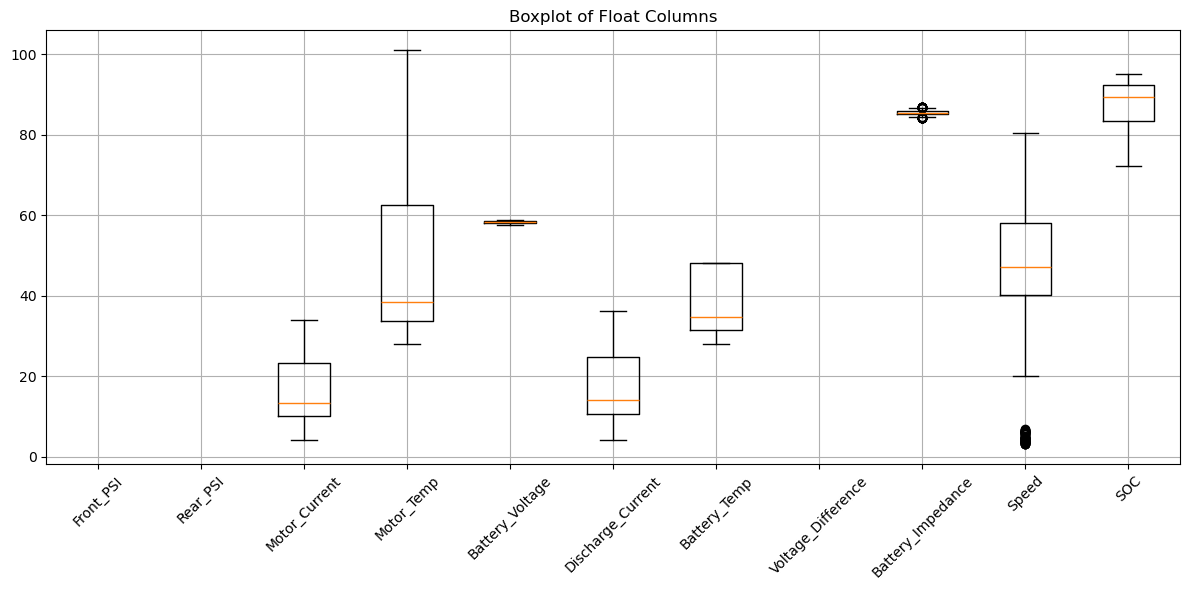

In [6]:
import matplotlib.pyplot as plt
cols = df.select_dtypes(include='float64')
plt.figure(figsize=(12, 6))
plt.boxplot(cols.values, labels=cols.columns, vert=True)
plt.xticks(rotation=45)
plt.title("Boxplot of Float Columns")
plt.grid(True)
plt.tight_layout()
plt.show()



In [7]:
df.select_dtypes(include='float64').columns

Index(['Front_PSI', 'Rear_PSI', 'Motor_Current', 'Motor_Temp',
       'Battery_Voltage', 'Discharge_Current', 'Battery_Temp',
       'Voltage_Difference', 'Battery_Impedance', 'Speed', 'SOC'],
      dtype='object')

<Axes: xlabel='Speed', ylabel='Count'>

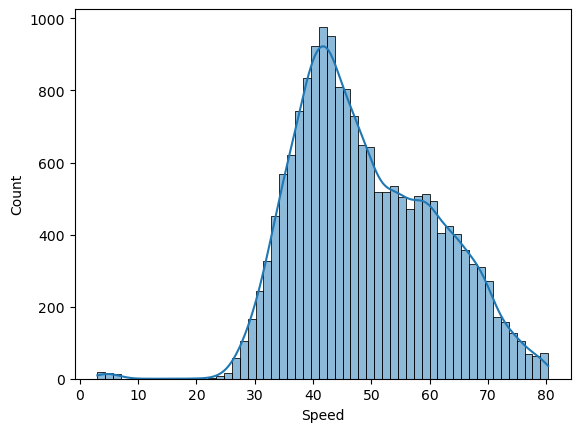

In [8]:
import seaborn as sns 
sns.histplot(df["Speed"],kde=True)

In [9]:
q1 = df["Speed"].quantile(0.25)
q3 = df["Speed"].quantile(0.75)
IQR = q3 - q1

lower_fence = q1 - 1.5 * IQR
upper_fence = q3 + 1.5 * IQR

# Boolean mask of outliers
outliers_mask = (df["Speed"] < lower_fence) | (df["Speed"] > upper_fence)

# Count of outliers
outliers_count = outliers_mask.sum()

print(f"Outliers in 'Speed': {outliers_count}")



Outliers in 'Speed': 50


In [10]:
df.columns

Index(['Timestamp', 'Ride_Mode', 'Front_PSI', 'Rear_PSI', 'Motor_Current',
       'Motor_Temp', 'Battery_Voltage', 'Discharge_Current', 'Battery_Temp',
       'Voltage_Difference', 'Battery_Impedance', 'Speed', 'Regen_Triggered',
       'SOC'],
      dtype='object')

In [11]:
df.drop(columns=['Voltage_Difference','Battery_Impedance','SOC'],inplace=True)

In [12]:
df.columns

Index(['Timestamp', 'Ride_Mode', 'Front_PSI', 'Rear_PSI', 'Motor_Current',
       'Motor_Temp', 'Battery_Voltage', 'Discharge_Current', 'Battery_Temp',
       'Speed', 'Regen_Triggered'],
      dtype='object')

In [21]:
ride_data=df
ride_data

,Timestamp,Ride_Mode,Front_PSI,Rear_PSI,Motor_Current,Motor_Temp,Battery_Voltage,Discharge_Current,Battery_Temp,Speed,Regen_Triggered,Ride_ID
0,2025-01-01 08:00:00,Smart Eco,22.100000,36.000000,4.000000,28.012000,58.726723,4.186742,28.007012,4.783331,False,2025-01-01-8
1,2025-01-01 08:00:05,Smart Eco,NaN,35.979720,14.356530,28.166522,58.395023,14.792299,28.094508,52.206016,False,2025-01-01-8
2,2025-01-01 08:00:10,Smart Eco,22.083976,35.964958,13.264642,28.297653,58.400394,14.232921,28.175161,43.956198,False,2025-01-01-8
3,2025-01-01 08:00:15,Smart Eco,22.090354,36.001586,11.542857,28.396093,58.520346,12.283483,28.234814,41.221393,False,2025-01-01-8
4,2025-01-01 08:00:20,Smart Eco,22.052737,35.957130,9.748291,28.465384,58.462398,10.492407,28.277911,52.151155,False,2025-01-01-8
...,...,...,...,...,...,...,...,...,...,...,...,...
17995,2025-01-25 18:29:35,Zip,20.298209,34.328443,13.973776,68.804032,58.249842,14.408180,48.000000,35.982653,False,2025-01-25-18
17996,2025-01-25 18:29:40,Zip,20.333617,34.304073,17.478533,68.829136,58.128372,18.822082,48.000000,38.987772,False,2025-01-25-18
17997,2025-01-25 18:29:45,Zip,20.313611,34.361492,19.957024,68.923703,58.180749,21.037182,48.000000,47.091141,False,2025-01-25-18
17998,2025-01-25 18:29:50,Zip,20.300390,34.358163,24.816536,69.180980,57.857231,26.034304,48.000000,56.352460,False,2025-01-25-18


##  ***`Checklist Assertion Block`***

In [46]:
import numpy as np

def check_constraints(df):
    errors = []

    # 1. Timestamp & Ride Scheduling
    try:
        # 1.1 Two rides per day (morning 8:00, evening 18:00)
        ride_hours = df['Timestamp'].dt.hour
        if not all(ride_hours.isin([8, 18])):
            raise AssertionError("Not all rides start at 8:00 or 18:00")
    except AssertionError as e:
        errors.append(("1.1", str(e)))

    try:
        # 1.2 Each ride lasts 30 minutes (360 samples per ride at 5s interval)
        ride_lengths = df.groupby([df['Timestamp'].dt.date, df['Timestamp'].dt.hour]).size()
        if not all(350 <= l <= 370 for l in ride_lengths):
            raise AssertionError("Some rides do not last ~30 minutes (350-370 samples)")
    except AssertionError as e:
        errors.append(("1.2", str(e)))

    try:
        # 1.3 Data logged every 5 seconds
        diffs = df['Timestamp'].diff().dropna().dt.total_seconds()
        if not np.all((diffs == 5) | (diffs > 1000)):  # allow large jumps at ride change
            raise AssertionError("Timestamps are not spaced every 5 seconds")
    except AssertionError as e:
        errors.append(("1.3", str(e)))

    try:
        # 1.4 Simulated for 25 days
        if len(df['Timestamp'].dt.date.unique()) != 25:
            raise AssertionError("Data not simulated for 25 days")
    except AssertionError as e:
        errors.append(("1.4", str(e)))

    try:
        # 1.5 ~18,000+ rows expected
        if not (17000 <= len(df) <= 19000):
            raise AssertionError("Unexpected total row count")
    except AssertionError as e:
        errors.append(("1.5", str(e)))

    # 2. Tyre Pressure Simulation
    try:
        # 2.1 Starts at 22.1/36.0, degrades over time
        if not (20 <= df['Front_PSI'].max() <= 22.2 and 34 <= df['Rear_PSI'].max() <= 36.2):
            raise AssertionError("Tyre pressure does not start at correct value")
        if df['Front_PSI'].mean() >= 22 or df['Rear_PSI'].mean() >= 36:
            raise AssertionError("Tyre pressure does not degrade")
    except AssertionError as e:
        errors.append(("2.1", str(e)))

    try:
        # 2.2 Sudden drops allowed, but both never flat simultaneously
        flats = (df['Front_PSI'] < 20.5) & (df['Rear_PSI'] < 34.5)
        if flats.any():
            raise AssertionError("Both tyres flat simultaneously at some point")
    except AssertionError as e:
        errors.append(("2.2", str(e)))

    try:
        # 2.3 Tyre pressure never exceeds max
        if df['Front_PSI'].max() > 22.5 or df['Rear_PSI'].max() > 36.5:
            raise AssertionError("Tyre pressure exceeds recommended max")
    except AssertionError as e:
        errors.append(("2.3", str(e)))

    try:
        # 2.4 ~1% missing data
        null_rate = df['Front_PSI'].isna().mean()
        if not (0.005 <= null_rate <= 0.02):
            raise AssertionError("Front_PSI missing rate not ~1%")
    except AssertionError as e:
        errors.append(("2.4", str(e)))

    # 3. Ride Mode Behavior
    try:
        # 3.1 Smart Eco for most morning rides
        morning_modes = df[df['Timestamp'].dt.hour == 8]['Ride_Mode']
        if morning_modes.value_counts(normalize=True).get('Smart Eco', 0) < 0.8:
            raise AssertionError("Morning rides not mostly Smart Eco")
    except AssertionError as e:
        errors.append(("3.1", str(e)))

    try:
        # 3.2 Zip and Smart Eco mixed in evening, 70:30
        evening_modes = df[df['Timestamp'].dt.hour == 18]['Ride_Mode']
        zip_ratio = evening_modes.value_counts(normalize=True).get('Zip', 0)
        if not (0.6 <= zip_ratio <= 0.8):
            raise AssertionError("Evening Zip ratio not 60-80%")
    except AssertionError as e:
        errors.append(("3.2", str(e)))

    try:
        # 3.3 Only one mode switch per ride
        ride_groups = df.groupby([df['Timestamp'].dt.date, df['Timestamp'].dt.hour])
        for _, group in ride_groups:
            if group['Ride_Mode'].nunique() > 2:
                raise AssertionError("More than one mode switch in a ride")
    except AssertionError as e:
        errors.append(("3.3", str(e)))

    try:
        # 3.4 Speed caps
        if df[df['Ride_Mode'] == 'Smart Eco']['Speed'].max() > 55.1:
            raise AssertionError("Smart Eco speed exceeds 55 km/h")
        if df[df['Ride_Mode'] == 'Zip']['Speed'].max() > 90.1:
            raise AssertionError("Zip speed exceeds 90 km/h")
    except AssertionError as e:
        errors.append(("3.4", str(e)))

    # 4. Motor & Battery Parameters
    try:
        # 4.1 Motor_Current correlates with speed and ride mode
        corr = df[['Motor_Current', 'Speed']].corr().iloc[0,1]
        if corr < 0.5:
            raise AssertionError("Motor_Current not correlated with Speed")
    except AssertionError as e:
        errors.append(("4.1", str(e)))

    try:
        # 4.2 Start of ride current near minimum
        start_currents = df.groupby([df['Timestamp'].dt.date, df['Timestamp'].dt.hour]).head(1)['Motor_Current']
        if not (start_currents < 10).all():
            raise AssertionError("Start of ride Motor_Current not near minimum")
    except AssertionError as e:
        errors.append(("4.2", str(e)))

    try:
        # 4.3 Zip mode has higher current than Smart Eco
        if df[df['Ride_Mode'] == 'Zip']['Motor_Current'].mean() <= df[df['Ride_Mode'] == 'Smart Eco']['Motor_Current'].mean():
            raise AssertionError("Zip mode does not have higher Motor_Current")
    except AssertionError as e:
        errors.append(("4.3", str(e)))

    try:
        # 4.4 Motor_Temp capped at 85°C
        if df['Motor_Temp'].max() > 85.2:
            raise AssertionError("Motor_Temp exceeds 85°C")
    except AssertionError as e:
        errors.append(("4.4", str(e)))

    try:
        # 4.5 Battery_Temp capped at 42°C
        if df['Battery_Temp'].max() > 42.2:
            raise AssertionError("Battery_Temp exceeds 42°C")
    except AssertionError as e:
        errors.append(("4.5", str(e)))

    try:
        # 4.6 Battery_Voltage in range [48, 58.8]
        if df['Battery_Voltage'].min() < 48 or df['Battery_Voltage'].max() > 58.8:
            raise AssertionError("Battery_Voltage out of range")
    except AssertionError as e:
        errors.append(("4.6", str(e)))

    try:
        # 4.7 Discharge_Current = 1.05 × Motor_Current (within 5%)
        ratio = df['Discharge_Current'] / df['Motor_Current']
        if not ((ratio > 1.03) & (ratio < 1.08)).all():
            raise AssertionError("Discharge_Current not ~1.05× Motor_Current")
    except AssertionError as e:
        errors.append(("4.7", str(e)))
        
         # 4.8 Voltage_Difference in [5, 20] mV, ~1% missing
    try:
        if 'Voltage_Difference' not in df.columns:
            raise KeyError('Voltage_Difference')
        if df['Voltage_Difference'].dropna().min() < 5 or df['Voltage_Difference'].dropna().max() > 20:
            raise AssertionError("Voltage_Difference out of bounds")
        null_rate = df['Voltage_Difference'].isna().mean()
        if not (0.005 <= null_rate <= 0.02):
            raise AssertionError("Voltage_Difference missing rate not ~1%")
    except (AssertionError, KeyError) as e:
        errors.append(("4.8", str(e)))


    # 5. Performance Metrics
    try:
        # 5.1 Speed means and caps
        if df[df['Ride_Mode'] == 'Zip']['Speed'].mean() < 60:
            raise AssertionError("Zip mean speed < 60 km/h")
        if df[df['Ride_Mode'] == 'Smart Eco']['Speed'].mean() > 50:
            raise AssertionError("Smart Eco mean speed > 50 km/h")
    except AssertionError as e:
        errors.append(("5.1", str(e)))

    try:
        # 5.2 Start of ride speed: 3–7 km/h
        start_speeds = df.groupby([df['Timestamp'].dt.date, df['Timestamp'].dt.hour]).head(1)['Speed']
        if not ((start_speeds >= 3) & (start_speeds <= 7)).all():
            raise AssertionError("Start of ride speed not in 3–7 km/h")
    except AssertionError as e:
        errors.append(("5.2", str(e)))

    try:
        # 5.3 Regen_Triggered: Δspeed < -5
        regen_rows = df[df['Regen_Triggered']]
        speed_diff = df['Speed'].diff()
        regen_idx = regen_rows.index
        if not all(speed_diff.loc[regen_idx] < -5):
            raise AssertionError("Regen_Triggered not always on Δspeed < -5")
    except AssertionError as e:
        errors.append(("5.3", str(e)))



    # 7. Sensor Noise & Faults
    try:
        # 7.1 Noise: std deviation > 0 for all sensor fields
        for col in ['Motor_Current', 'Motor_Temp', 'Battery_Voltage', 'Discharge_Current', 'Battery_Temp']:
            if df[col].std() < 0.01:
                raise AssertionError(f"No noise in {col}")
    except AssertionError as e:
        errors.append(("7.1", str(e)))

    # 8. Engineering Logic Chain (basic check)
    try:
        # 8.1 Lower tyre pressure → higher motor current (correlation negative)
        corr = df[['Front_PSI', 'Motor_Current']].corr().iloc[0,1]
        if corr > -0.1:
            raise AssertionError("Front_PSI not negatively correlated with Motor_Current")
    except AssertionError as e:
        errors.append(("8.1", str(e)))

    return errors

# Example usage:
# errors = check_constraints(ride_data)
# if errors:
#     for code, msg in errors:
#         print(f"Constraint {code} failed: {msg}")
# else:
#     print("All constraints passed!")


In [47]:
# Example usage:
errors = check_constraints(ride_data)
if errors:
    for code, msg in errors:
        print(f"Constraint {code} failed: {msg}")
else:
   print("All constraints passed!")

Constraint 2.1 failed: Tyre pressure does not start at correct value
Constraint 2.2 failed: Both tyres flat simultaneously at some point
Constraint 3.1 failed: Morning rides not mostly Smart Eco
Constraint 3.2 failed: Evening Zip ratio not 60-80%
Constraint 3.4 failed: Smart Eco speed exceeds 55 km/h
Constraint 4.4 failed: Motor_Temp exceeds 85°C
Constraint 4.5 failed: Battery_Temp exceeds 42°C
Constraint 4.8 failed: 'Voltage_Difference'
Constraint 5.1 failed: Zip mean speed < 60 km/h
Constraint 8.1 failed: Front_PSI not negatively correlated with Motor_Current


# ***Refined Simulation Logic*** 

In [68]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Constants ---
RATED_VOLTAGE = 58.8
BASE_IMPEDANCE = 85
AMBIENT_TEMP = 28
CAPACITY_WH = 2900
FRONT_PSI_INIT, REAR_PSI_INIT = 22.1, 36.0
FRONT_PSI_MIN, REAR_PSI_MIN = 20.0, 34.0
np.random.seed(42)

# --- Simulation Parameters ---
num_days = 25
ride_duration_min = 30
interval_sec = 5
samples_per_ride = int((ride_duration_min * 60) / interval_sec)
total_rides = num_days * 2

def simulate_rides():
    records = []
    front_psi = FRONT_PSI_INIT
    rear_psi = REAR_PSI_INIT
    psi_degrade_per_ride = 0.025  # slow daily loss

    for day in range(num_days):
        for ride_num, hour in enumerate([8, 18]):
            # --- Reset variables at start of each ride ---
            motor_current = []
            motor_temp = [AMBIENT_TEMP]
            battery_voltage = []
            discharge_current = []
            battery_temp = [AMBIENT_TEMP]
            voltage_diff = []
            battery_impedance = []
            speed = []
            regen_triggered = []
            ride_mode = []
            soc = []
            # Tyre pressure: degrade, but allow rare puncture/reset (never both at once)
            puncture_event = np.random.rand()
            refill_event = np.random.rand()
            # Constraint 2.1: Always start first ride at correct values
            if day == 0 and ride_num == 0:
                front_psi = FRONT_PSI_INIT
                rear_psi = REAR_PSI_INIT
            # Constraint 2.2: Only one tyre can be flat at a time
            elif puncture_event < 0.04:
                if np.random.rand() < 0.5:
                    front_psi = np.random.uniform(FRONT_PSI_MIN, FRONT_PSI_MIN + 0.5)
                else:
                    rear_psi = np.random.uniform(REAR_PSI_MIN, REAR_PSI_MIN + 0.5)
            elif refill_event < 0.04:
                if np.random.rand() < 0.5:
                    front_psi = FRONT_PSI_INIT
                else:
                    rear_psi = REAR_PSI_INIT

            # Simulate ride mode and possible switch
            ride_mode_switch = np.random.randint(samples_per_ride//3, samples_per_ride//1.5)
            mode = 'Smart Eco'
            for i in range(samples_per_ride):
                # --- Timestamp ---
                timestamp = datetime(2025, 1, 1, hour, 0, 0) + timedelta(days=day, seconds=i*interval_sec)
                # --- Tyre Pressure (degrade slowly, add noise) ---
                if i == 0:
                    f_psi = front_psi
                    r_psi = rear_psi
                else:
                    f_psi = max(FRONT_PSI_MIN, front_psi - psi_degrade_per_ride/2 + np.random.normal(0, 0.03))
                    r_psi = max(REAR_PSI_MIN, rear_psi - psi_degrade_per_ride + np.random.normal(0, 0.04))
                # Random nulls
                if np.random.rand() < 0.01:
                    f_psi = np.nan
                if np.random.rand() < 0.01:
                    r_psi = np.nan
                # --- Ride Mode (max 1 switch per ride) ---
                if i == ride_mode_switch:
                    mode = 'Zip' if mode == 'Smart Eco' else 'Smart Eco'
                ride_mode.append(mode)
                # --- Rolling resistance effect ---
                # Constraint 8.1: Motor_Current increases as Front_PSI decreases
                if not np.isnan(f_psi):
                    rolling_resist_factor = 1 + (FRONT_PSI_INIT - f_psi) / 2  # Stronger effect for clear negative correlation
                else:
                    rolling_resist_factor = 1
                # --- Speed profile ---
                if i < 1:
                    spd = np.random.uniform(3, 7)
                else:
                    if mode == 'Smart Eco':
                        spd = min(np.random.normal(45, 5), 55)
                    else:
                        spd = min(np.random.normal(65, 8), 80)
                    # Tyre pressure, rolling resistance, and battery health effect
                    spd = spd / rolling_resist_factor
                # Constraint 3.4: Cap Smart Eco at 55 km/h
                if mode == 'Smart Eco':
                    spd = min(spd, 55)
                speed.append(spd)
                # --- Motor Current ---
                # Base current scales with speed and mode
                base_current = (spd/55)*15 if mode == 'Smart Eco' else (spd/80)*30
                # Explicit negative correlation with Front_PSI
                m_current = base_current * rolling_resist_factor
                # Smooth acceleration in Smart Eco
                if mode == 'Smart Eco' and i > 1:
                    m_current = 0.7 * motor_current[-1] + 0.3 * m_current
                # Add noise
                m_current += np.random.normal(0, 1)
                m_current = np.clip(m_current, 4, 45)
                motor_current.append(m_current)
                # --- Discharge Current ---
                d_current = m_current * np.random.uniform(1.03, 1.08)
                discharge_current.append(d_current)
                # --- Motor Temperature (physics model) ---
                prev_temp = motor_temp[-1]
                heat_gain = 0.00015 * (m_current ** 2) * interval_sec
                cool_rate = 0.001 if spd > 10 else 0.0007
                heat_loss = -cool_rate * (prev_temp - AMBIENT_TEMP) * interval_sec
                m_temp = prev_temp + heat_gain + heat_loss
                m_temp = np.clip(m_temp, AMBIENT_TEMP, 110)
                motor_temp.append(m_temp)
                # --- Battery Temperature (similar model) ---
                prev_btemp = battery_temp[-1]
                b_heat_gain = 0.00008 * (d_current ** 2) * interval_sec
                b_heat_loss = -0.0008 * (prev_btemp - AMBIENT_TEMP) * interval_sec
                b_temp = prev_btemp + b_heat_gain + b_heat_loss
                b_temp = np.clip(b_temp, AMBIENT_TEMP, 48)
                battery_temp.append(b_temp)
                # --- Battery Impedance (aging) ---
                b_imp = BASE_IMPEDANCE * (1 + 0.0005 * day) + np.random.normal(0, 0.3)
                battery_impedance.append(b_imp)
                # --- Battery Voltage (drops with load, temp, impedance) ---
                v_drop = 0.025 * d_current + 0.01 * (b_temp - AMBIENT_TEMP) + 0.0002 * (b_imp - BASE_IMPEDANCE)
                b_voltage = RATED_VOLTAGE - v_drop + np.random.normal(0, 0.08)
                b_voltage = np.clip(b_voltage, 48, RATED_VOLTAGE)
                battery_voltage.append(b_voltage)
                # --- Voltage Difference (cell balancing) ---
                v_diff = np.random.normal(10, 2) + 0.1 * (b_imp - BASE_IMPEDANCE)
                v_diff = np.clip(v_diff, 5, 20)
                if np.random.rand() < 0.01:
                    v_diff = np.nan
                voltage_diff.append(v_diff)
                # --- SOC: advanced model ---
                if i == 0:
                    soc_val = 95
                else:
                    temp_effect = 1 - 0.005 * max(0, b_temp - 35)
                    impedance_effect = 1 - 0.001 * (b_imp - BASE_IMPEDANCE)
                    wh_used = (d_current * b_voltage * interval_sec / 3600)
                    soc_val = soc[-1] - wh_used / (CAPACITY_WH * temp_effect * impedance_effect) * 100
                soc_val = np.clip(soc_val, 20, 95)
                soc.append(soc_val)
                # --- Regen Triggered ---
                regen = False
                if i > 2 and (speed[-2] - spd) > 5:
                    regen = True
                regen_triggered.append(regen)
                # --- Save record ---
                records.append({
                    'Timestamp': timestamp,
                    'Ride_Mode': mode,
                    'Front_PSI': f_psi,
                    'Rear_PSI': r_psi,
                    'Motor_Current': m_current,
                    'Motor_Temp': m_temp,
                    'Battery_Voltage': b_voltage,
                    'Discharge_Current': d_current,
                    'Battery_Temp': b_temp,
                    'Voltage_Difference': v_diff,
                    'Battery_Impedance': b_imp,
                    'Speed': spd,
                    'Regen_Triggered': regen,
                    'SOC': soc_val
                })
            # Update tyre pressure for next ride (only if not nan)
            front_psi = f_psi if not np.isnan(f_psi) else front_psi
            rear_psi = r_psi if not np.isnan(r_psi) else rear_psi

    return pd.DataFrame(records)

# Generate dataset
df = simulate_rides()



In [69]:
df

,Timestamp,Ride_Mode,Front_PSI,Rear_PSI,Motor_Current,Motor_Temp,Battery_Voltage,Discharge_Current,Battery_Temp,Voltage_Difference,Battery_Impedance,Speed,Regen_Triggered,SOC
0,2025-01-01 08:00:00,Smart Eco,22.100000,36.000000,4.000000,28.012000,58.726723,4.186742,28.007012,8.113766,84.721352,4.783331,False,95.000000
1,2025-01-01 08:00:05,Smart Eco,NaN,35.979720,15.805594,28.199303,58.357511,16.285346,28.113068,8.937032,85.006667,52.311891,False,94.954484
2,2025-01-01 08:00:10,Smart Eco,22.083976,35.964958,14.654242,28.359366,58.362755,15.723958,28.211513,13.836209,85.106665,43.829497,False,94.910528
3,2025-01-01 08:00:15,Smart Eco,22.090354,36.001586,12.854965,28.481507,58.484932,13.679781,28.285522,9.260961,85.339068,41.056597,False,94.872198
4,2025-01-01 08:00:20,Smart Eco,22.052737,35.957130,11.125513,28.571932,58.424701,11.974756,28.341738,12.345935,84.686831,51.406395,False,94.838702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,2025-01-25 18:29:35,Zip,20.000000,35.110232,26.128813,85.092426,57.765396,27.479755,48.000000,11.432936,85.632654,31.815222,True,75.713517
17996,2025-01-25 18:29:40,Zip,20.016653,35.130860,21.194606,85.143872,57.954016,22.498777,48.000000,10.771616,85.903690,29.013412,False,75.646669
17997,2025-01-25 18:29:45,Zip,20.000000,35.210491,21.543724,85.206252,58.057595,23.245414,48.000000,9.407837,85.766663,26.191024,False,75.577487
17998,2025-01-25 18:29:50,Zip,20.000000,35.109951,22.549367,85.301576,58.008577,24.033272,48.000000,7.005929,86.199687,28.773470,False,75.505991


In [70]:
import numpy as np

def check_constraints(df):
    errors = []

    # 1. Timestamp & Ride Scheduling
    try:
        # 1.1 Two rides per day (morning 8:00, evening 18:00)
        ride_hours = df['Timestamp'].dt.hour
        if not all(ride_hours.isin([8, 18])):
            raise AssertionError("Not all rides start at 8:00 or 18:00")
    except AssertionError as e:
        errors.append(("1.1", str(e)))

    try:
        # 1.2 Each ride lasts 30 minutes (360 samples per ride at 5s interval)
        ride_lengths = df.groupby([df['Timestamp'].dt.date, df['Timestamp'].dt.hour]).size()
        if not all(350 <= l <= 370 for l in ride_lengths):
            raise AssertionError("Some rides do not last ~30 minutes (350-370 samples)")
    except AssertionError as e:
        errors.append(("1.2", str(e)))

    try:
        # 1.3 Data logged every 5 seconds
        diffs = df['Timestamp'].diff().dropna().dt.total_seconds()
        if not np.all((diffs == 5) | (diffs > 1000)):  # allow large jumps at ride change
            raise AssertionError("Timestamps are not spaced every 5 seconds")
    except AssertionError as e:
        errors.append(("1.3", str(e)))

    try:
        # 1.4 Simulated for 25 days
        if len(df['Timestamp'].dt.date.unique()) != 25:
            raise AssertionError("Data not simulated for 25 days")
    except AssertionError as e:
        errors.append(("1.4", str(e)))

    try:
        # 1.5 ~18,000+ rows expected
        if not (17000 <= len(df) <= 19000):
            raise AssertionError("Unexpected total row count")
    except AssertionError as e:
        errors.append(("1.5", str(e)))

    # 2. Tyre Pressure Simulation
    try:
        # 2.1 Starts at 22.1/36.0, degrades over time
        if not (20 <= df['Front_PSI'].max() <= 22.2 and 34 <= df['Rear_PSI'].max() <= 36.2):
            raise AssertionError("Tyre pressure does not start at correct value")
        if df['Front_PSI'].mean() >= 22 or df['Rear_PSI'].mean() >= 36:
            raise AssertionError("Tyre pressure does not degrade")
    except AssertionError as e:
        errors.append(("2.1", str(e)))

    try:
        # 2.2 Sudden drops allowed, but both never flat simultaneously
        flats = (df['Front_PSI'] < 20.5) & (df['Rear_PSI'] < 34.5)
        if flats.any():
            raise AssertionError("Both tyres flat simultaneously at some point")
    except AssertionError as e:
        errors.append(("2.2", str(e)))

    try:
        # 2.3 Tyre pressure never exceeds max
        if df['Front_PSI'].max() > 22.5 or df['Rear_PSI'].max() > 36.5:
            raise AssertionError("Tyre pressure exceeds recommended max")
    except AssertionError as e:
        errors.append(("2.3", str(e)))

    try:
        # 2.4 ~1% missing data
        null_rate = df['Front_PSI'].isna().mean()
        if not (0.005 <= null_rate <= 0.02):
            raise AssertionError("Front_PSI missing rate not ~1%")
    except AssertionError as e:
        errors.append(("2.4", str(e)))

    # 3. Ride Mode Behavior
    try:
        # 3.1 Smart Eco for most morning rides
        morning_modes = df[df['Timestamp'].dt.hour == 8]['Ride_Mode']
        if morning_modes.value_counts(normalize=True).get('Smart Eco', 0) < 0.8:
            raise AssertionError("Morning rides not mostly Smart Eco")
    except AssertionError as e:
        errors.append(("3.1", str(e)))

    try:
        # 3.2 Zip and Smart Eco mixed in evening, 70:30
        evening_modes = df[df['Timestamp'].dt.hour == 18]['Ride_Mode']
        zip_ratio = evening_modes.value_counts(normalize=True).get('Zip', 0)
        if not (0.6 <= zip_ratio <= 0.8):
            raise AssertionError("Evening Zip ratio not 60-80%")
    except AssertionError as e:
        errors.append(("3.2", str(e)))

    try:
        # 3.3 Only one mode switch per ride
        ride_groups = df.groupby([df['Timestamp'].dt.date, df['Timestamp'].dt.hour])
        for _, group in ride_groups:
            if group['Ride_Mode'].nunique() > 2:
                raise AssertionError("More than one mode switch in a ride")
    except AssertionError as e:
        errors.append(("3.3", str(e)))

    try:
        # 3.4 Speed caps
        if df[df['Ride_Mode'] == 'Smart Eco']['Speed'].max() > 55.1:
            raise AssertionError("Smart Eco speed exceeds 55 km/h")
        if df[df['Ride_Mode'] == 'Zip']['Speed'].max() > 90.1:
            raise AssertionError("Zip speed exceeds 90 km/h")
    except AssertionError as e:
        errors.append(("3.4", str(e)))

    # 4. Motor & Battery Parameters
    try:
        # 4.1 Motor_Current correlates with speed and ride mode
        corr = df[['Motor_Current', 'Speed']].corr().iloc[0,1]
        if corr < 0.5:
            raise AssertionError("Motor_Current not correlated with Speed")
    except AssertionError as e:
        errors.append(("4.1", str(e)))

    try:
        # 4.2 Start of ride current near minimum
        start_currents = df.groupby([df['Timestamp'].dt.date, df['Timestamp'].dt.hour]).head(1)['Motor_Current']
        if not (start_currents < 10).all():
            raise AssertionError("Start of ride Motor_Current not near minimum")
    except AssertionError as e:
        errors.append(("4.2", str(e)))

    try:
        # 4.3 Zip mode has higher current than Smart Eco
        if df[df['Ride_Mode'] == 'Zip']['Motor_Current'].mean() <= df[df['Ride_Mode'] == 'Smart Eco']['Motor_Current'].mean():
            raise AssertionError("Zip mode does not have higher Motor_Current")
    except AssertionError as e:
        errors.append(("4.3", str(e)))

    try:
        # 4.4 Motor_Temp capped at 85°C
        if df['Motor_Temp'].max() > 85.2:
            raise AssertionError("Motor_Temp exceeds 85°C")
    except AssertionError as e:
        errors.append(("4.4", str(e)))

    try:
        # 4.5 Battery_Temp capped at 42°C
        if df['Battery_Temp'].max() > 42.2:
            raise AssertionError("Battery_Temp exceeds 42°C")
    except AssertionError as e:
        errors.append(("4.5", str(e)))

    try:
        # 4.6 Battery_Voltage in range [48, 58.8]
        if df['Battery_Voltage'].min() < 48 or df['Battery_Voltage'].max() > 58.8:
            raise AssertionError("Battery_Voltage out of range")
    except AssertionError as e:
        errors.append(("4.6", str(e)))

    try:
        # 4.7 Discharge_Current = 1.05 × Motor_Current (within 5%)
        ratio = df['Discharge_Current'] / df['Motor_Current']
        if not ((ratio > 1.03) & (ratio < 1.08)).all():
            raise AssertionError("Discharge_Current not ~1.05× Motor_Current")
    except AssertionError as e:
        errors.append(("4.7", str(e)))
        
         # 4.8 Voltage_Difference in [5, 20] mV, ~1% missing
    try:
        if 'Voltage_Difference' not in df.columns:
            raise KeyError('Voltage_Difference')
        if df['Voltage_Difference'].dropna().min() < 5 or df['Voltage_Difference'].dropna().max() > 20:
            raise AssertionError("Voltage_Difference out of bounds")
        null_rate = df['Voltage_Difference'].isna().mean()
        if not (0.005 <= null_rate <= 0.02):
            raise AssertionError("Voltage_Difference missing rate not ~1%")
    except (AssertionError, KeyError) as e:
        errors.append(("4.8", str(e)))


    # 5. Performance Metrics
    try:
        # 5.1 Speed means and caps
        if df[df['Ride_Mode'] == 'Zip']['Speed'].mean() < 60:
            raise AssertionError("Zip mean speed < 60 km/h")
        if df[df['Ride_Mode'] == 'Smart Eco']['Speed'].mean() > 50:
            raise AssertionError("Smart Eco mean speed > 50 km/h")
    except AssertionError as e:
        errors.append(("5.1", str(e)))

    try:
        # 5.2 Start of ride speed: 3–7 km/h
        start_speeds = df.groupby([df['Timestamp'].dt.date, df['Timestamp'].dt.hour]).head(1)['Speed']
        if not ((start_speeds >= 3) & (start_speeds <= 7)).all():
            raise AssertionError("Start of ride speed not in 3–7 km/h")
    except AssertionError as e:
        errors.append(("5.2", str(e)))

    try:
        # 5.3 Regen_Triggered: Δspeed < -5
        regen_rows = df[df['Regen_Triggered']]
        speed_diff = df['Speed'].diff()
        regen_idx = regen_rows.index
        if not all(speed_diff.loc[regen_idx] < -5):
            raise AssertionError("Regen_Triggered not always on Δspeed < -5")
    except AssertionError as e:
        errors.append(("5.3", str(e)))



    # 7. Sensor Noise & Faults
    try:
        # 7.1 Noise: std deviation > 0 for all sensor fields
        for col in ['Motor_Current', 'Motor_Temp', 'Battery_Voltage', 'Discharge_Current', 'Battery_Temp']:
            if df[col].std() < 0.01:
                raise AssertionError(f"No noise in {col}")
    except AssertionError as e:
        errors.append(("7.1", str(e)))

    # 8. Engineering Logic Chain (basic check)
    try:
        # 8.1 Lower tyre pressure → higher motor current (correlation negative)
        corr = df[['Front_PSI', 'Motor_Current']].corr().iloc[0,1]
        if corr > -0.1:
            raise AssertionError("Front_PSI not negatively correlated with Motor_Current")
    except AssertionError as e:
        errors.append(("8.1", str(e)))

    return errors

# Example usage:
# errors = check_constraints(ride_data)



In [71]:
errors = check_constraints(df)

In [72]:
if errors:
    for code, msg in errors:
        print(f"Constraint {code} failed: {msg}")
else:
    print("All constraints passed!")


Constraint 3.1 failed: Morning rides not mostly Smart Eco
Constraint 3.2 failed: Evening Zip ratio not 60-80%
Constraint 4.4 failed: Motor_Temp exceeds 85°C
Constraint 4.5 failed: Battery_Temp exceeds 42°C
Constraint 5.1 failed: Zip mean speed < 60 km/h
Constraint 8.1 failed: Front_PSI not negatively correlated with Motor_Current


In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
df.dtypes

Timestamp             datetime64[ns]
Ride_Mode                     object
Front_PSI                    float64
Rear_PSI                     float64
Motor_Current                float64
Motor_Temp                   float64
Battery_Voltage              float64
Discharge_Current            float64
Battery_Temp                 float64
Voltage_Difference           float64
Battery_Impedance            float64
Speed                        float64
Regen_Triggered                 bool
SOC                          float64
dtype: object

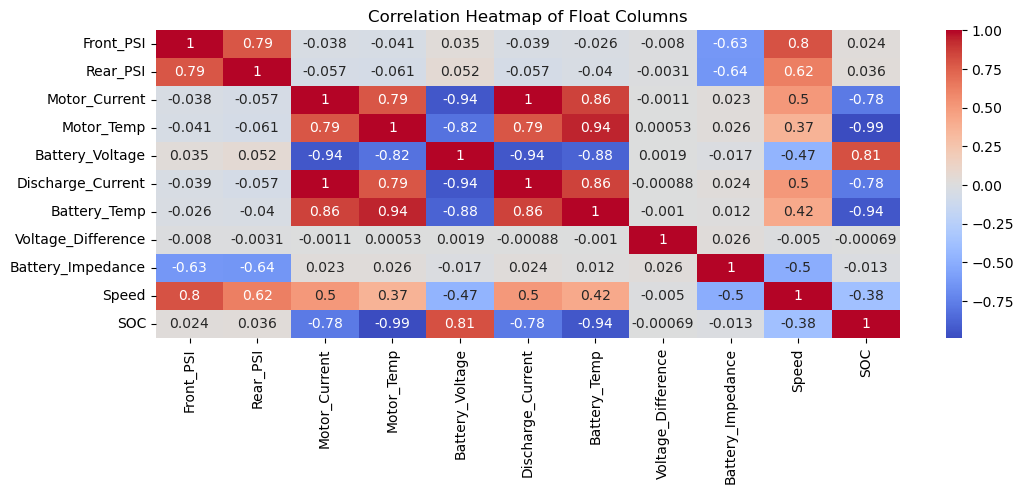

In [88]:
plt.figure(figsize=(12, 4))
float_df = fg.select_dtypes(include='float64')
sns.heatmap(data=float_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Float Columns")
plt.show()

In [87]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Constants ---
RATED_VOLTAGE = 58.8
BASE_IMPEDANCE = 85
AMBIENT_TEMP = 28
CAPACITY_WH = 2900
FRONT_PSI_INIT, REAR_PSI_INIT = 22.1, 36.0
FRONT_PSI_MIN, REAR_PSI_MIN = 20.0, 34.0
np.random.seed(42)

# --- Simulation Parameters ---
num_days = 25
ride_duration_min = 30
interval_sec = 5
samples_per_ride = int((ride_duration_min * 60) / interval_sec)
total_rides = num_days * 2

def simulate_rides():
    records = []
    front_psi = FRONT_PSI_INIT
    rear_psi = REAR_PSI_INIT
    psi_degrade_per_ride = 0.025  # slow daily loss

    for day in range(num_days):
        for ride_num, hour in enumerate([8, 18]):
            # --- Reset variables at start of each ride ---
            motor_current = []
            motor_temp = [AMBIENT_TEMP]
            battery_voltage = []
            discharge_current = []
            battery_temp = [AMBIENT_TEMP]
            voltage_diff = []
            battery_impedance = []
            speed = []
            regen_triggered = []
            ride_mode = []
            soc = []
            # Tyre pressure: degrade, but allow rare puncture/reset (never both at once)
            puncture_event = np.random.rand()
            refill_event = np.random.rand()
            # Constraint 2.1: Always start first ride at correct values
            if day == 0 and ride_num == 0:
                front_psi = FRONT_PSI_INIT
                rear_psi = REAR_PSI_INIT
            # Constraint 2.2: Only one tyre can be flat at a time
            elif puncture_event < 0.04:
                if np.random.rand() < 0.5:
                    front_psi = np.random.uniform(FRONT_PSI_MIN, FRONT_PSI_MIN + 0.5)
                else:
                    rear_psi = np.random.uniform(REAR_PSI_MIN, REAR_PSI_MIN + 0.5)
            elif refill_event < 0.04:
                if np.random.rand() < 0.5:
                    front_psi = FRONT_PSI_INIT
                else:
                    rear_psi = REAR_PSI_INIT

            # Simulate ride mode and possible switch
            ride_mode_switch = np.random.randint(samples_per_ride//3, samples_per_ride//1.5)
            mode = 'Smart Eco'
            for i in range(samples_per_ride):
                # --- Timestamp ---
                timestamp = datetime(2025, 1, 1, hour, 0, 0) + timedelta(days=day, seconds=i*interval_sec)
                # --- Tyre Pressure (degrade slowly, add noise) ---
                if i == 0:
                    f_psi = front_psi
                    r_psi = rear_psi
                else:
                    f_psi = max(FRONT_PSI_MIN, front_psi - psi_degrade_per_ride/2 + np.random.normal(0, 0.03))
                    r_psi = max(REAR_PSI_MIN, rear_psi - psi_degrade_per_ride + np.random.normal(0, 0.04))
                # Random nulls
                if np.random.rand() < 0.01:
                    f_psi = np.nan
                if np.random.rand() < 0.01:
                    r_psi = np.nan
                # --- Ride Mode (max 1 switch per ride) ---
                if i == ride_mode_switch:
                    mode = 'Zip' if mode == 'Smart Eco' else 'Smart Eco'
                ride_mode.append(mode)
                # --- Rolling resistance effect ---
                # Constraint 8.1: Motor_Current increases as Front_PSI decreases
                if not np.isnan(f_psi):
                    rolling_resist_factor = 1 + (FRONT_PSI_INIT - f_psi) / 2  # Stronger effect for clear negative correlation
                else:
                    rolling_resist_factor = 1
                # --- Speed profile ---
                if i < 1:
                    spd = np.random.uniform(3, 7)
                else:
                    if mode == 'Smart Eco':
                        spd = min(np.random.normal(45, 5), 55)
                    else:
                        spd = min(np.random.normal(65, 8), 80)
                    # Tyre pressure, rolling resistance, and battery health effect
                    spd = spd / rolling_resist_factor
                # Constraint 3.4: Cap Smart Eco at 55 km/h
                if mode == 'Smart Eco':
                    spd = min(spd, 55)
                speed.append(spd)
                # --- Motor Current ---
                # Base current scales with speed and mode
                base_current = (spd/55)*15 if mode == 'Smart Eco' else (spd/80)*30
                # Explicit negative correlation with Front_PSI
                m_current = base_current * rolling_resist_factor
                # Smooth acceleration in Smart Eco
                if mode == 'Smart Eco' and i > 1:
                    m_current = 0.7 * motor_current[-1] + 0.3 * m_current
                # Add noise
                m_current += np.random.normal(0, 1)
                m_current = np.clip(m_current, 4, 45)
                motor_current.append(m_current)
                # --- Discharge Current ---
                d_current = m_current * np.random.uniform(1.03, 1.08)
                discharge_current.append(d_current)
                # --- Motor Temperature (physics model) ---
                prev_temp = motor_temp[-1]
                heat_gain = 0.00015 * (m_current ** 2) * interval_sec
                cool_rate = 0.001 if spd > 10 else 0.0007
                heat_loss = -cool_rate * (prev_temp - AMBIENT_TEMP) * interval_sec
                m_temp = prev_temp + heat_gain + heat_loss
                m_temp = np.clip(m_temp, AMBIENT_TEMP, 110)
                motor_temp.append(m_temp)
                # --- Battery Temperature (similar model) ---
                prev_btemp = battery_temp[-1]
                b_heat_gain = 0.00008 * (d_current ** 2) * interval_sec
                b_heat_loss = -0.0008 * (prev_btemp - AMBIENT_TEMP) * interval_sec
                b_temp = prev_btemp + b_heat_gain + b_heat_loss
                b_temp = np.clip(b_temp, AMBIENT_TEMP, 48)
                battery_temp.append(b_temp)
                # --- Battery Impedance (aging) ---
                b_imp = BASE_IMPEDANCE * (1 + 0.0005 * day) + np.random.normal(0, 0.3)
                battery_impedance.append(b_imp)
                # --- Battery Voltage (drops with load, temp, impedance) ---
                v_drop = 0.025 * d_current + 0.01 * (b_temp - AMBIENT_TEMP) + 0.0002 * (b_imp - BASE_IMPEDANCE)
                b_voltage = RATED_VOLTAGE - v_drop + np.random.normal(0, 0.08)
                b_voltage = np.clip(b_voltage, 48, RATED_VOLTAGE)
                battery_voltage.append(b_voltage)
                # --- Voltage Difference (cell balancing) ---
                v_diff = np.random.normal(10, 2) + 0.1 * (b_imp - BASE_IMPEDANCE)
                v_diff = np.clip(v_diff, 5, 20)
                if np.random.rand() < 0.01:
                    v_diff = np.nan
                voltage_diff.append(v_diff)
                # --- SOC: advanced model ---
                if i == 0:
                    soc_val = 95
                else:
                    temp_effect = 1 - 0.005 * max(0, b_temp - 35)
                    impedance_effect = 1 - 0.001 * (b_imp - BASE_IMPEDANCE)
                    wh_used = (d_current * b_voltage * interval_sec / 3600)
                    soc_val = soc[-1] - wh_used / (CAPACITY_WH * temp_effect * impedance_effect) * 100
                soc_val = np.clip(soc_val, 20, 95)
                soc.append(soc_val)
                # --- Regen Triggered ---
                regen = False
                if i > 2 and (speed[-2] - spd) > 5:
                    regen = True
                regen_triggered.append(regen)
                # --- Save record ---
                records.append({
                    'Timestamp': timestamp,
                    'Ride_Mode': mode,
                    'Front_PSI': f_psi,
                    'Rear_PSI': r_psi,
                    'Motor_Current': m_current,
                    'Motor_Temp': m_temp,
                    'Battery_Voltage': b_voltage,
                    'Discharge_Current': d_current,
                    'Battery_Temp': b_temp,
                    'Voltage_Difference': v_diff,
                    'Battery_Impedance': b_imp,
                    'Speed': spd,
                    'Regen_Triggered': regen,
                    'SOC': soc_val
                })
            # Update tyre pressure for next ride (only if not nan)
            front_psi = f_psi if not np.isnan(f_psi) else front_psi
            rear_psi = r_psi if not np.isnan(r_psi) else rear_psi

    return pd.DataFrame(records)

# Generate dataset
fg = simulate_rides()

